In [16]:
import polars as ps
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2


In [13]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Reading the nessecary files

In [4]:
#-----------already_done_running---------------
# df = ps.read_parquet('C:/Users/diyac/AIandBioProject/ts.parquet')
# pandas_df = df.to_pandas()
# events = pd.read_csv("C:/Users/diyac/AIandBioProject/train_events.csv")
# pandas_df['series_id'].value_counts()
# train_events_csv = pd.read_csv('C:/Users/diyac/Downloads/child-mind-institute-detect-sleep-states-20231119T201923Z-001/train_events.csv')

### Creating the new csv using the zipper function 

In [5]:
def fillValue(i, flag, val, merged_df_patient):
    merged_df_patient.iloc[i,9]=val

def generate_merged(newdf, pandas_df, csv_file):    
    newdf['label'] = newdf['event']
    awake_mask = (newdf['label'] == 'onset') | (newdf['label'] == 'wakeup')
    newdf['y_target'] = awake_mask.cumsum()
    newdf.loc[newdf['label'] == 'onset', 'y_target'] = 0
    newdf['y_target'] = newdf['y_target'].fillna(method='ffill')
    flag=1
    for i in range(len(newdf)):
        #print("current i value : "+str(i))
        if newdf.iloc[i,8]=='onset' or newdf.iloc[i,8]=='wakeup':
            if newdf.iloc[i,8]=='onset':
                flag=flag*(-1)
                fillValue(i,flag,1,newdf)
            if newdf.iloc[i,8]=='wakeup':
                flag=flag*(-1)
                fillValue(i,flag,0,newdf)

        elif flag==1:
            fillValue(i,flag,0,newdf)
        else:
            fillValue(i, flag,1,newdf)
    return newdf    

def merging_patients(series_id_list): 
    columns = ['series_id', 'step', 'timestamp_x', 'anglez', 'enmo', 'night', 'event', 'timestamp_y', 'label', 'y_target']
    patient_log = pd.DataFrame(columns=columns)
    for i in range(len(series_id_list)): 
        patient_train_events=train_events_csv[train_events_csv['series_id'] == series_id_list[i]]
        patient_df = pandas_df[pandas_df['series_id'] == series_id_list[i]]
        patient_train_events=patient_train_events.dropna()
        patient_train_events['step'] = patient_train_events['step'].astype(int)
        merged_df_patient = pd.merge(patient_df, patient_train_events, on=['series_id', 'step'], how='left')
        merged_df_patient =generate_merged(merged_df_patient, patient_df, patient_train_events)
        print(i,": done")  
        patient_log=pd.concat([patient_log, merged_df_patient], ignore_index=True)
    return patient_log


In [6]:
#----------already_created_the edit file
# np.random.seed(0)
# unique_series_ids  = pandas_df['series_id'].value_counts().index.to_numpy()
# randomly_selected_names = np.random.choice(unique_series_ids, size=3, replace=False)
# print("Randomly selected names:", randomly_selected_names)
# shortlisted_patients = merging_patients(randomly_selected_names)


Randomly selected names: ['1b92be89db4c' '655f19eabf1e' '5c55a5e717d6']
0 : done
1 : done
2 : done


In [9]:
shortlisted_patients.to_csv("C:/Users/diyac/Detect_Sleep_States/patientLog.csv")

In [19]:
train_dataset = pd.read_csv("C:/Users/diyac/Detect_Sleep_States/patientLog.csv")
train_dataset = train_dataset.drop(['Unnamed: 0', 'timestamp_x', 'night', 'event', 'timestamp_y', 'label'], axis=1)
train_dataset


,series_id,step,anglez,enmo,y_target
0,1b92be89db4c,0,87.1277,0.0033,0
1,1b92be89db4c,1,88.1777,0.0091,0
2,1b92be89db4c,2,88.2099,0.0030,0
3,1b92be89db4c,3,88.1331,0.0017,0
4,1b92be89db4c,4,87.9545,0.0015,0
...,...,...,...,...,...
1172875,5c55a5e717d6,397255,-0.4428,0.0068,0
1172876,5c55a5e717d6,397256,-1.2413,0.0009,0
1172877,5c55a5e717d6,397257,-1.7075,0.0009,0
1172878,5c55a5e717d6,397258,-0.3891,0.0025,0


In [26]:
# Separate features (X) and target (Y)
X = train_dataset.drop(columns=['y_target', 'series_id', 'step'])
Y = train_dataset['y_target']

### Baseline MLP Model

In [21]:


# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Build the MLP model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/5
29322/29322 [==============================] - 70s 2ms/step - loss: 0.4559 - accuracy: 0.7719 - val_loss: 0.4238 - val_accuracy: 0.7927
Epoch 2/5
29322/29322 [==============================] - 68s 2ms/step - loss: 0.4332 - accuracy: 0.7905 - val_loss: 0.4193 - val_accuracy: 0.7930
Epoch 3/5
29322/29322 [==============================] - 68s 2ms/step - loss: 0.4346 - accuracy: 0.7913 - val_loss: 0.4134 - val_accuracy: 0.8016
Epoch 4/5
29322/29322 [==============================] - 68s 2ms/step - loss: 0.4357 - accuracy: 0.7911 - val_loss: 0.4133 - val_accuracy: 0.8059
Epoch 5/5
7331/7331 [==============================] - 11s 2ms/step - loss: 0.4156 - accuracy: 0.8069
Test Loss: 0.4156, Test Accuracy: 80.69%


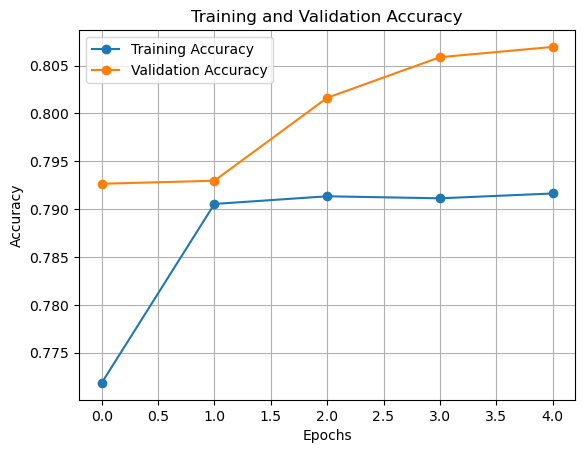

In [33]:

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
#plt.autoscale(axis='y', tight=True)
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


### Basic LSTM Model

In [29]:
# Convert DataFrame to NumPy array
X_array = X.to_numpy()

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_array)

# Reshape to 3D
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Build an LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.01, epsilon=1e-7)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/5
29322/29322 [==============================] - 226s 8ms/step - loss: 0.4714 - accuracy: 0.7587 - val_loss: 0.4346 - val_accuracy: 0.7752
Epoch 2/5
29322/29322 [==============================] - 224s 8ms/step - loss: 0.4456 - accuracy: 0.7836 - val_loss: 0.4253 - val_accuracy: 0.7936
Epoch 3/5
29322/29322 [==============================] - 222s 8ms/step - loss: 0.4422 - accuracy: 0.7876 - val_loss: 0.4168 - val_accuracy: 0.8073
Epoch 4/5
29322/29322 [==============================] - 169s 6ms/step - loss: 0.4409 - accuracy: 0.7891 - val_loss: 0.4243 - val_accuracy: 0.7949
Epoch 5/5
7331/7331 [==============================] - 16s 2ms/step - loss: 0.4159 - accuracy: 0.8018
Test Loss: 0.4159, Test Accuracy: 80.18%


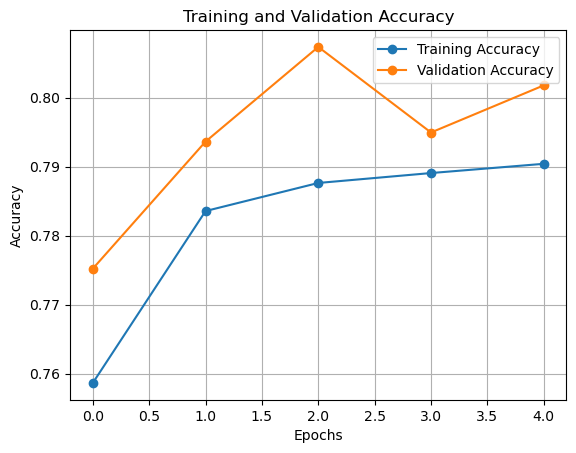

In [34]:
# Plot training accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', marker='o')
#plt.autoscale(axis='y', tight=True)
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

### Improved LSTM model

In [32]:
# Convert DataFrame to NumPy array
X_array = X.to_numpy()

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_array)

# Reshape to 3D
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Build an LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', return_sequences=True))  # Additional LSTM layer
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))  # Another LSTM layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001, epsilon=1e-7)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))  # Increased epochs

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
3666/3666 [==============================] - 50s 12ms/step - loss: 0.5085 - accuracy: 0.7409 - val_loss: 0.4302 - val_accuracy: 0.8016
Epoch 2/10
3666/3666 [==============================] - 44s 12ms/step - loss: 0.4486 - accuracy: 0.7848 - val_loss: 0.4193 - val_accuracy: 0.7994
Epoch 3/10
3666/3666 [==============================] - 42s 12ms/step - loss: 0.4393 - accuracy: 0.7906 - val_loss: 0.4163 - val_accuracy: 0.8001
Epoch 4/10
3666/3666 [==============================] - 44s 12ms/step - loss: 0.4360 - accuracy: 0.7927 - val_loss: 0.4139 - val_accuracy: 0.8004
Epoch 5/10
3666/3666 [==============================] - 42s 12ms/step - loss: 0.4327 - accuracy: 0.7942 - val_loss: 0.4128 - val_accuracy: 0.8006
Epoch 6/10
3666/3666 [==============================] - 42s 11ms/step - loss: 0.4302 - accuracy: 0.7956 - val_loss: 0.4124 - val_accuracy: 0.7984
Epoch 7/10
3666/3666 [==============================] - 39s 11ms/step - loss: 0.4281 - accuracy: 0.7966 - val_loss: 0.4105 -

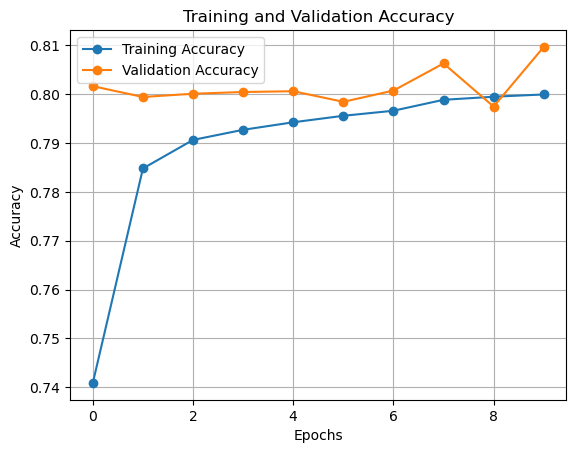

In [35]:
# Plot training accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
#plt.autoscale(axis='y', tight=True)
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()